<a href="https://colab.research.google.com/github/gpfer/projektR/blob/main/klasifikacija.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [86]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dohvatimo kategorije

In [87]:
import base64
import requests

master = "https://raw.githubusercontent.com/gpfer/projektR/main/dataset/klasifikacija.csv"
req = requests.get(master)
req = req.text

Keirajmo kategije od podataka: [in-day, in-night, out-day, out-night]

In [88]:
import numpy as np
import io

data = req
data = data.split('\n')

nd = []
for line in data[1:1708]:
  line = line.split(',')
  num = int(line[0])
  val = line[1] + '-' + line[2]
  nd.append([num, val])


data = np.array(nd)

cats = np.unique(data[:, 1])
new_data = []
for d in data:
  new_data.append(np.where(cats == d[1])[0][0])
labels = torch.IntTensor(new_data)
labels

tensor([2, 2, 2,  ..., 3, 2, 2], dtype=torch.int32)

#Ucitajmo slike

Primjer

torch.Size([3, 512, 341])


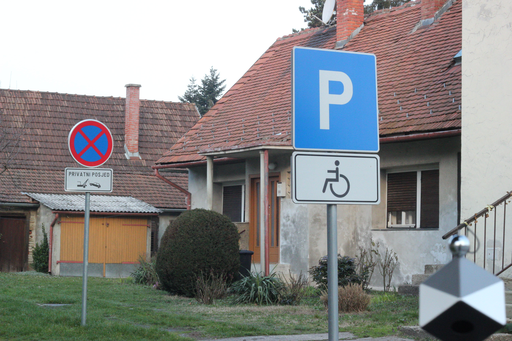

In [89]:
from PIL import Image

img = Image.open("/content/drive/My Drive/JPG/1.JPG")

basewidth = 512
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
arr = np.asarray(img, dtype='float32')
arr /= 65536
arr = arr * 256
arr = arr - 2048
arr[arr<0] = 0
arr = torch.from_numpy(arr)
arr = arr.transpose(0,2)
print(arr.shape)
img

Ucitajmo sve slike.

In [90]:
root = "/content/drive/My Drive/JPG"

train_images = []
test_images = []

for i in range(1, 1708):
  name = str(i) + ".JPG"
  img = Image.open(root + '/' + name)
  basewidth = 128
  wpercent = (basewidth/float(img.size[0]))
  hsize = int((float(img.size[1])*float(wpercent)))
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)
  a = np.asarray(img, dtype='float32')
  a = a * 256
  a = a - 2048
  a[a<0] = 0
  a /= 65536
  a = torch.from_numpy(a)
  a = a.transpose(0,2)
  if i < int(0.8*1707):
    train_images.append(a)
  else:
    test_images.append(a)

Pripremimo slike za neuronsku mrezu

In [91]:
train_images = torch.stack(train_images)
test_images = torch.stack(test_images)
print(train_images.shape, test_images.shape)

train_labels = labels[:int(0.8*len(labels))-1]
test_labels = labels[int(0.8*len(labels))-1:]
print(train_labels.shape, test_labels.shape)

torch.Size([1364, 3, 128, 85]) torch.Size([343, 3, 128, 85])
torch.Size([1364]) torch.Size([343])


In [92]:
train_images = train_images.type(torch.FloatTensor)
test_images = test_images.type(torch.FloatTensor)
print(train_images.dtype)

train_labels = train_labels.type(torch.LongTensor)
test_labels = test_labels.type(torch.LongTensor)
print(test_labels.dtype)

train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

torch.float32
torch.int64


# Kreiramo nuronsku mrezu

In [93]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=5)

    self.fc1 = nn.Linear(5376, 1000)
    self.fc2 = nn.Linear(1000, 200)
    self.fc3 = nn.Linear(200, 4)

    self.batch = nn.BatchNorm1d(1000)
    
    self.maxpool = nn.MaxPool2d(kernel_size=2)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.conv3(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = x.view(-1, 5376)
    x = self.fc1(x)
    x = self.relu(x)

    x = self.batch(x)

    x = self.fc2(x)
    x = self.relu(x)

    x = self.fc3(x)
    x = self.relu(x)

    return F.log_softmax(x, dim=1)

In [125]:
n_epochs = 10
learning_rate = 0.00005
device = 'cuda'

Metoda za korak treniranja

In [95]:
def train_step(network, train_data, epoch, device):
  losses = []
  counter = []

  network.train()
  for idx, (data, target) in enumerate(train_data):
    data = data.to(device)
    target = target.to(device)

    network.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    if idx % 5 == 0:
      print('Train Epoch: {:2d}, ({:2.0f}%), Loss: {:.5f}'.format(
          epoch, 100*idx*64/len(train_data.dataset), loss
      ))
      losses.append(loss)
      counter.append(idx*64 + (epoch-1)*len(train_data.dataset))

  return losses, counter

Metoda za testiranje

In [96]:
def test(network, test_data, device):
  network.eval()

  loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_data:
      data = data.to(device)
      target = target.to(device)

      output = network(data)
      loss += F.nll_loss(output, target, reduction="sum").item()
      prediction = output.data.max(1, keepdim=True)[1]
      correct += prediction.eq(target.data.view_as(prediction)).sum()

  loss /= len(test_data.dataset)
  accuracy = 100 * correct / len(test_data.dataset)

  print('\nTest loss: {:.3f}, Accuracy: {:4d}/{:4d} ({:2.2f}%)'.format(
      loss, correct, len(test_data.dataset), accuracy
  ))

  return loss, accuracy

In [97]:
def train(network, train_data, test_data, device='cuda'):
  test_loss = []
  test_acc = []
  train_loss = []
  counter = []

  # testiramo pocetni model
  loss_t, acc_t = test(network, test_data, device)
  test_loss.append(loss_t)
  test_acc.append(acc_t)

  for epoch in range(1, n_epochs+1):
    # korak i test
    loss, cnt = train_step(network, train_data, epoch, device)
    loss_t, acc_t = test(network, test_data, device)

    test_loss.append(loss_t)
    test_acc.append(acc_t)
    train_loss.append(loss)
    counter.append(cnt)

  return test_loss, test_acc, train_loss, counter


Kreiranje i treniranje mreze


In [128]:
network = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [129]:
test_loss, test_acc, train_loss, counter = train(network, train_loader, test_loader, device)


Test loss: 1.350, Accuracy:  274/ 343 (79.88%)
Train Epoch:  1, ( 0%), Loss: 1.30277
Train Epoch:  1, (23%), Loss: 1.07241
Train Epoch:  1, (47%), Loss: 0.90257
Train Epoch:  1, (70%), Loss: 0.88260
Train Epoch:  1, (94%), Loss: 0.71378

Test loss: 1.240, Accuracy:  282/ 343 (82.22%)
Train Epoch:  2, ( 0%), Loss: 0.73987
Train Epoch:  2, (23%), Loss: 0.82615
Train Epoch:  2, (47%), Loss: 0.67288
Train Epoch:  2, (70%), Loss: 0.68459
Train Epoch:  2, (94%), Loss: 0.59900

Test loss: 1.203, Accuracy:  281/ 343 (81.92%)
Train Epoch:  3, ( 0%), Loss: 0.49370
Train Epoch:  3, (23%), Loss: 0.49468
Train Epoch:  3, (47%), Loss: 0.49590
Train Epoch:  3, (70%), Loss: 0.47013
Train Epoch:  3, (94%), Loss: 0.52108

Test loss: 0.851, Accuracy:  300/ 343 (87.46%)
Train Epoch:  4, ( 0%), Loss: 0.48939
Train Epoch:  4, (23%), Loss: 0.45280
Train Epoch:  4, (47%), Loss: 0.47146
Train Epoch:  4, (70%), Loss: 0.48157
Train Epoch:  4, (94%), Loss: 0.36319

Test loss: 0.800, Accuracy:  296/ 343 (86.30%)


# Vizualizacija modela
